In [ ]:
## loading of kaggle key and then downloading the dataset through the kaggle api

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mustafaaaahmed","key":"e947594c8f6a94abf89d0dcc3346692f"}'}

In [1]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98% 1.31G/1.33G [00:08<00:00, 229MB/s]
100% 1.33G/1.33G [00:08<00:00, 170MB/s]


In [2]:
!unzip celeba-dataset.zip -d celeba-dataset

Streaming output truncated to the last 5000 lines.
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba-dataset/img_align_celeba/img_

In [3]:
import tensorflow as tf
from tensorflow.keras import utils, layers, metrics, models, optimizers

train_data = utils.image_dataset_from_directory(
"/content/celeba-dataset",
labels=None,
color_mode="rgb",
image_size=(64, 64),
batch_size=128,
shuffle=True,
seed=42,
interpolation="bilinear",
)

def preprocess(img):
   img = tf.cast(img, "float32") / 255.0
   return img

train = train_data.map(lambda x: preprocess(x))



Found 202599 files.


In [4]:
class Sampling(layers.Layer):
   def call(self, inputs):
     z_mean, z_log_var = inputs
     batch = tf.shape(z_mean)[0]
     dim = tf.shape(z_mean)[1]
     epsilon = K.random_normal(shape=(batch, dim))
     return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
## training the Variational autoencoder

import tensorflow.keras.backend as K
from tensorflow.keras import models

encoder_input = layers.Input(shape=(64, 64, 3), name="encoder_input")
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(96, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(200, name="z_mean")(x) ## These dimensions they will act like channels
z_log_var = layers.Dense(200, name="z_log_var")(x) ## The same goes for this as well
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

In [6]:
## Now lets start the decoder

import numpy as np

decoder_input = layers.Input(shape=(200,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) ## Starting with the dense layer
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(96, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x= layers.Conv2DTranspose(64,(3,3), strides=2, activation='relu',padding="same")(x)
decoder_output = layers.Conv2D(1,(3, 3),strides = 1,activation="sigmoid",padding="same",name="decoder_output")(x) ## Because strides 1 i took as Conv2d
decoder = models.Model(decoder_input, decoder_output)




In [11]:
## custom class for the VAE

from tensorflow.keras import losses

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape: ## This here is the wrapper context in which we use the record the required operation during the forward pass and then outside the
            z_mean, z_log_var, reconstruction = self(data, training=True) ## the indented space of this wrapper we use the backward pass i.e gradients updations
            reconstruction_loss = tf.reduce_mean(
                500 * losses.mse(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            500 * losses.mse(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }







In [12]:
## training the vae model and fitting the data

vae= VAE(encoder,decoder)

vae.compile(optimizer="adam")

vae.fit(train,
        epochs=2,
        batch_size=100
        )

Epoch 1/2
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 117s 66ms/step - kl_loss: 3.6889 - loss: 32.5792 - reconstruction_loss: 28.8903
Epoch 2/2
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 95s 60ms/step - kl_loss: 5.1314 - loss: 26.1630 - reconstruction_loss: 21.0316


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


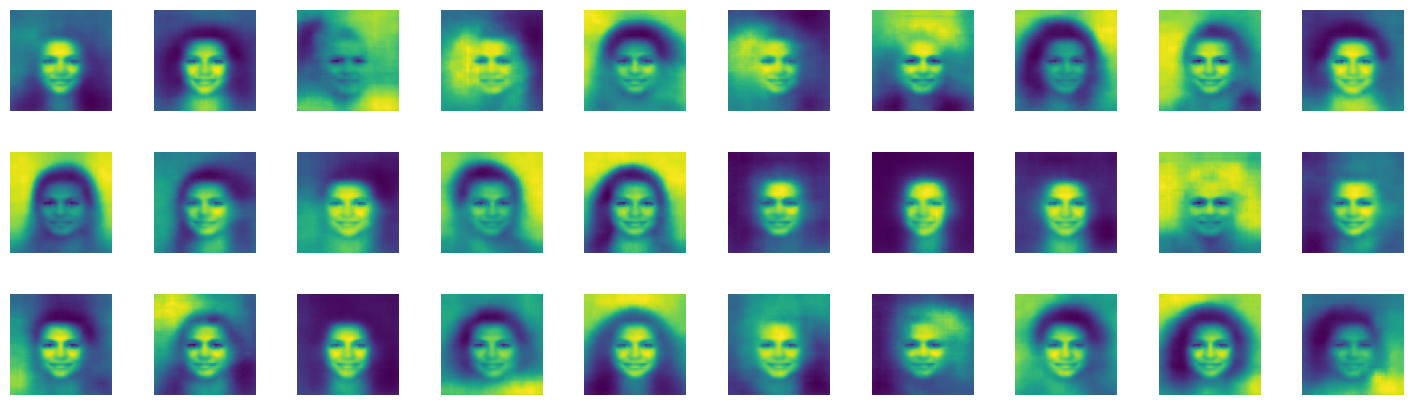

In [16]:
## Generating new faces
import matplotlib.pyplot as plt
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size=(grid_width * grid_height, 200)) ## z sample for the the decoder since i need a z sample to sample from so i took 3o points sampled with 200 dims

reconstructions = decoder.predict(z_sample)
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width * grid_height):
   ax = fig.add_subplot(grid_height, grid_width, i + 1)
   ax.axis("off")
   ax.imshow(reconstructions[i, :, :])